In [1]:
import sys
import os
from time import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import io as sio
from skimage import measure
from scipy.optimize import linear_sum_assignment

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'

model_cfg = '../configs/model_cfgs/pipeline6_rgbspec_san19pairfreeze_halluconv2_actreggru2_top3_cat.yaml'

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_flow(flow, num_segments, new_length):
    flow = flow.cpu().numpy()
    assert flow.shape[0] == 1
    _, _, h, w = flow.shape
    flow = flow.reshape([num_segments, new_length, 2, h, w])
    flow *= 1  # std
    flow += 128  # mean
    flow = flow.astype(np.uint8)
    flow_x = flow[:, :, 0, :, :]
    flow_y = flow[:, :, 1, :, :]
    return flow_x, flow_y


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [3]:
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
# model_params['num_segments'] = 25
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

for k in ['low_feat_model_cfg', 'high_feat_model_cfg', 'hallu_model_cfg', 'actreg_model_cfg',
          'spatial_sampler_cfg', 'temporal_sampler_cfg',
          'hallu_pretrained_weights', 'actreg_pretrained_weights']:
    model_params[k] = '../'+model_params[k]

# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model = model.to(device)
model.eval()

# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [4]:
sample_id = 64

# Get a sample
sample, _ = val_loader.dataset[sample_id]
sample = {k: v.unsqueeze(dim=0).to(device) for k, v in sample.items()}

# Forward
rgb_high = sample['RGB']
rgb_low = rgb_high[:, :, ::2, ::2]
spec = sample['Spec']

rgb_low = rgb_low.view((-1, model.num_segments, 3) + rgb_low.size()[-2:])[0]
rgb_high = rgb_high.view((-1, model.num_segments, 3) + rgb_high.size()[-2:])[0]
spec = spec.view((-1, model.num_segments, 1) + spec.size()[-2:])[0]

with torch.no_grad():
    # Attention
    model.low_feat_model.rgb(rgb_low)
    attn = model.low_feat_model.rgb.get_attention_weight(
        l_name=model.attention_layer[0],
        m_name=model.attention_layer[1],
        aggregated=True,
        )
    attn_dict = model.low_feat_model.rgb.get_all_attention_weights(aggregated=True)

    # Hallucination
    #hallu, _ = model.hallu_model(attn.unsqueeze(dim=0), None)
    #hallu = hallu[0]

layer0-0: default (0.051, 3.386) --> normalized (0.008, 0.383)
layer0-1: default (0.496, 1.459) --> normalized (0.076, 0.250)
layer0-2: default (0.271, 1.451) --> normalized (0.030, 0.169)
layer1-0: default (0.131, 3.829) --> normalized (0.006, 0.113)
layer1-1: default (0.224, 3.157) --> normalized (0.011, 0.064)
layer1-2: default (0.076, 4.125) --> normalized (0.002, 0.088)
layer2-0: default (0.098, 3.515) --> normalized (0.003, 0.085)
layer2-1: default (0.117, 4.713) --> normalized (0.005, 0.168)
layer2-2: default (0.184, 2.556) --> normalized (0.007, 0.061)
layer2-3: default (0.276, 2.743) --> normalized (0.008, 0.072)
layer3-0: default (0.223, 1.987) --> normalized (0.009, 0.124)
layer3-1: default (0.106, 3.029) --> normalized (0.005, 0.108)
layer3-2: default (0.004, 4.862) --> normalized (0.000, 0.173)
layer3-3: default (0.090, 7.309) --> normalized (0.004, 0.261)
layer3-4: default (0.185, 1.692) --> normalized (0.007, 0.106)
layer3-5: default (0.084, 2.209) --> normalized (0.003,

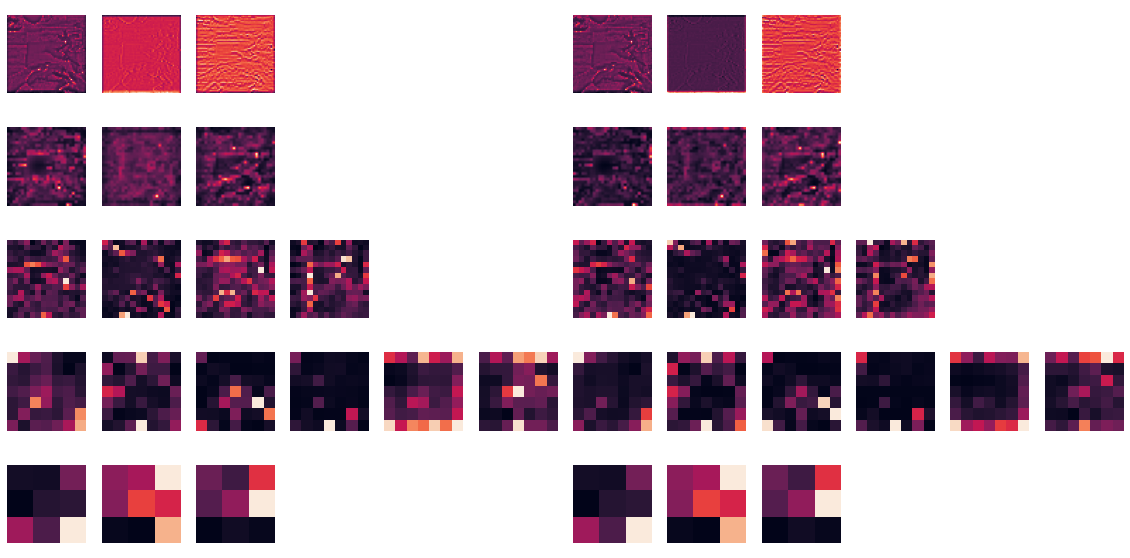

In [5]:
import torch.nn.functional as F

kernel_sizes = [3, 7, 7, 7, 7]

fig, axes = plt.subplots(5, 6*2, figsize=(20, 10))
for i, l_name in enumerate(attn_dict):
    kernel_size = kernel_sizes[i]
    padding = 2 * (kernel_size//2)
    for j, m_name in enumerate(attn_dict[l_name]):
        H = attn_dict[l_name][m_name].shape[-1]
        norm_mask = F.conv2d(torch.ones(1, 1, H, H),
                     torch.ones(1, 1, kernel_size, kernel_size),
                     padding=padding).to(attn.device)
        norm_mask_unpad = norm_mask[:, :,
                                    kernel_size//2:-kernel_size//2+1,
                                    kernel_size//2:-kernel_size//2+1]
        #print(norm_mask[0, 0, 0])

        #print(attn_dict[l_name][m_name].shape, norm_mask.shape, norm_mask_unpad.shape)
        foo = attn_dict[l_name][m_name][0].mean(dim=0)
        bar = (attn_dict[l_name][m_name] / norm_mask_unpad)[0].mean(dim=0)
        
        axes[i, j].imshow(foo.cpu().detach())
        axes[i, j+6].imshow(bar.cpu().detach())
        print('{}-{}: default ({:.03f}, {:.03f}) --> normalized ({:.03f}, {:.03f})'.format(
            l_name, m_name, foo.min().item(), foo.max().item(), bar.min().item(), bar.max().item()))
for ax in axes.ravel():
    ax.axis('off')